In [1]:
!pip install pandas numpy transformers torch


[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import sqlite3
from transformers import pipeline

c:\Users\amind\Desktop\projekt mupy\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def extract(csv_path):
    df = pd.read_csv(csv_path)
    return df


In [3]:
def explore(df):
    print("Första rader:")
    display(df.head())

    print("\nInfo:")
    print(df.info())

    print("\nSaknade värden:")
    print(df.isna().sum())

In [4]:
def clean_data(df):
    df = df.copy()

    df.columns = df.columns.str.lower().str.strip()

    if "order_date" in df.columns:
        df["order_date"] = pd.to_datetime(df["order_date"], errors="coerce")

    for col in ["price", "quantity", "delivery_days"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    df.fillna({
        "price": df["price"].median() if "price" in df.columns else 0,
        "quantity": 1,
        "delivery_days": df["delivery_days"].median() if "delivery_days" in df.columns else 0,
        "review_text": ""
    }, inplace=True)

    if "quantity" in df.columns:
        df = df[df["quantity"] > 0]

    return df


In [5]:
def add_features(df):
    df = df.copy()

    if "order_date" in df.columns:
        df["weekday"] = df["order_date"].dt.day_name()
        df["month"] = df["order_date"].dt.month
        df["week"] = df["order_date"].dt.isocalendar().week

    if {"price", "quantity"}.issubset(df.columns):
        df["total_sales"] = df["price"] * df["quantity"]

    return df

In [6]:
def add_sentiment(df):
    df = df.copy()

    if "review_text" not in df.columns:
        df["sentiment"] = "neutral"
        return df

    sentiment_model = pipeline(
        "sentiment-analysis",
        model="nlptown/bert-base-multilingual-uncased-sentiment"
    )

    def classify(text):
        if text.strip() == "":
            return "neutral"

        label = sentiment_model(text[:512])[0]["label"]
        score = int(label[0])

        if score <= 2:
            return "negative"
        elif score == 3:
            return "neutral"
        else:
            return "positive"

    df["sentiment"] = df["review_text"].apply(classify)
    return df


In [7]:
DATA_DICTIONARY = {
    "order_date": "Datum då ordern lades",
    "price": "Pris per enhet (rensad)",
    "quantity": "Antal enheter",
    "delivery_days": "Leveranstid i dagar",
    "review_text": "Kundens recension",
    "weekday": "Veckodag",
    "month": "Månad",
    "week": "Vecka",
    "total_sales": "Pris * antal",
    "sentiment": "Positiv / Neutral / Negativ (BERT)"
}

In [9]:
def verify(engine, table_name):
    count = pd.read_sql(f"SELECT COUNT(*) FROM {table_name}", engine)
    print("Antal rader i databasen:", count.iloc[0, 0])

In [10]:
def run_pipeline(csv_path, table_name):
    df = extract(csv_path)
    explore(df)

    df = clean_data(df)
    df = add_features(df)
    df = add_sentiment(df)

    engine = load_to_sqlite(df, table_name)
    verify(engine, table_name)

    return df


In [109]:
df_raw = pd.read_csv("matkassen_data.csv")

In [72]:
df_raw.head()



,leverans_id,prenumeration_id,kund_id,pren_startdatum,paus_från,paus_till,pren_avslutsdatum,kasstyp,kostpreferens,antal_portioner,...,leveransdatum,postnummer,veckapris,leveransstatus,recept_1,recept_2,recept_3,omdöme_text,omdömesdatum,omdömesbetyg
0,LEV-2024-000001,PREN-1002,KUND-05001,2024-04-10,NaN,NaN,2024-07-16,Klassisk,Standard,4,...,2024-07-03,10393,699,Levererad,Panerad fisk med remouladsås,Kyckling Tikka Masala,Köttfärssås med pasta,Maten var jätte bra,2024-07-08,3.7
1,LEV-2024-000002,PREN-1003,KUND-05002,2024-06-12,NaN,NaN,2024-07-16,Familj,Standard,6,...,2024-07-02,40545,"919,00",Levererad,Chicken nuggets-sallad,Köttbullar med makaroner,Fiskpinnar med potatismos,Älskar att slippa planera middagar. Tack!,2024-07-07,4.0
2,LEV-2024-000003,PREN-1011,KUND-05010,2024-05-11,NaN,NaN,2024-07-16,Vegetarisk,Standard,4,...,2024-07-02,10686,709,Levererad,Falafel med hummus,Svamprisotto,Vegetarisk lasagne,Svamprisotto var verkligen inte gott. Slängde ...,2024-07-06,2.0
3,LEV-2024-000004,PREN-1017,KUND-05016,2024-05-26,NaN,NaN,2024-07-16,Snabb & Enkel,Laktosfri,4,...,2024-07-01,40695,689,Levererad,15-minuters wok,Toast med avokado och ägg,Snabb tomatsoppa,Priset är högt men sparar tid. På gränsen.,2024-07-06,3.0
4,LEV-2024-000005,PREN-1018,KUND-05017,2024-05-02,NaN,NaN,2024-07-16,KLASSISK,Standard,2,...,2024-07-01,21938,499,Levererad,Panerad fisk med remouladsås,Laxfile med potatismos,Pasta Carbonara,"Fungerar, men recepten börjar bli repetitiva.",2024-07-08,3.0


In [136]:
df_raw["pren_avslutsdatum"] = pd.to_datetime("2024-07-16")


In [135]:
df_raw["kostpreferens"] = df_raw["kostpreferens"].fillna("Standard")


In [134]:
df_raw["omdöme_text"] = df_raw["omdöme_text"].fillna("Maten var jätte bra")

In [133]:
df_raw["omdömesdatum"] = pd.to_datetime(
    df_raw["omdömesdatum"], errors="coerce"
)

df_raw["omdömesdatum"] = df_raw["omdömesdatum"].fillna(
    pd.to_datetime("2024-07-08")
)

In [131]:
df_raw["omdömesbetyg"] = pd.to_numeric(
    df_raw["omdömesbetyg"], errors="coerce"
)

df_raw["omdömesbetyg"] = df_raw["omdömesbetyg"].fillna(3.7)

In [65]:
df_raw.sample(10)

,leverans_id,prenumeration_id,kund_id,pren_startdatum,paus_från,paus_till,pren_avslutsdatum,kasstyp,kostpreferens,antal_portioner,...,leveransdatum,postnummer,veckapris,leveransstatus,recept_1,recept_2,recept_3,omdöme_text,omdömesdatum,omdömesbetyg
2352,LEV-2024-002353,PREN-1117,KUND-05116,2024-08-14,NaN,NaN,2024-07-16,Klassisk,Standard,0,...,2024-12-09,11923,699,Levererad,Laxfile med potatismos,Panerad fisk med remouladsås,Fläskfilé med gräddsås,Maten var jätte bra,2024-07-08,3.7
2526,LEV-2024-002527,PREN-1169,KUND-05168,2024-07-12,NaN,NaN,2024-07-16,Klassisk,Standard,6,...,2024-12-17,10273,899,Levererad,Laxfile med potatismos,Kycklinggryta med ris,Fläskfilé med gräddsås,Bra variation och tydliga instruktioner.,2024-12-22,5.0
2623,LEV-2024-002624,PREN-1117,KUND-05116,2024-08-14,NaN,NaN,2024-07-16,klassisk,Standard,4,...,2024-12-23,11923,699,Levererad,Köttfärssås med pasta,Panerad fisk med remouladsås,Pasta Carbonara,Bra variation och tydliga instruktioner.,2024-12-28,4.0
2177,LEV-2024-002178,PREN-1069,KUND-05068,2024-09-25,NaN,NaN,2024-07-16,Vegetarisk,Laktosfri,4,...,2024-12-03,10438,709,Levererad,Svamprisotto,Grönsaksgratäng,Pasta med pesto och mozarella,Överraskad över hur gott det blev! Ny favoritr...,2024-12-06,4.0
1805,LEV-2024-001806,PREN-1146,KUND-05145,2024-07-03,NaN,NaN,2024-07-16,Klassisk,Fläskfri,2,...,2024-11-13,41338,499,Levererad,Fläskfilé med gräddsås,Kyckling Tikka Masala,Biff med bearnaise,Maten var jätte bra,2024-07-08,3.7
138,LEV-2024-000139,PREN-1006,KUND-05005,2024-07-08,NaN,NaN,2024-07-16,Klassisk,Standard,2,...,2024-07-16,11395,499,Levererad,Panerad fisk med remouladsås,Köttfärssås med pasta,Fläskfilé med gräddsås,Maten var jätte bra,2024-07-08,3.7
693,LEV-2024-000694,PREN-1208,KUND-05207,2024-05-28,NaN,NaN,2024-07-16,Klassisk,Ingen preferens,2,...,2024-09-02,41957,499,Levererad,Panerad fisk med remouladsås,Biff med bearnaise,Laxfile med potatismos,"Helt okej, men inget speciellt denna vecka.",2024-09-09,3.0
2536,LEV-2024-002537,PREN-1191,KUND-05190,2024-10-17,NaN,NaN,2024-07-16,Vegetarisk,Standard,2,...,2024-12-17,20890,479,Levererad,Vegansk burrito bowl,Thai-curry med tofu,Falafel med hummus,Maten var jätte bra,2024-07-08,3.7
44,LEV-2024-000045,PREN-1166,KUND-05165,2024-05-14,NaN,NaN,2024-07-16,Familj,Standard,4,...,2024-07-03,50588,719,Levererad,Köttbullar med makaroner,Barnens favorit-pasta,Chicken nuggets-sallad,Maten var jätte bra,2024-07-08,3.7
291,LEV-2024-000292,PREN-1149,KUND-05148,2024-07-24,NaN,NaN,2024-07-16,Vegetarisk,Laktosfri,4,...,2024-07-29,10349,709,Levererad,Vegetarisk lasagne,Grönsaksgratäng,Falafel med hummus,Maten var jätte bra,2024-07-08,3.7


In [130]:
df_raw["leveransstatus"] = "Levererad"


In [82]:
df_raw = pd.read_csv("matkassen_validation.csv")

In [213]:
df_raw.sample(10)

,leverans_id,prenumeration_id,kund_id,pren_startdatum,paus_från,paus_till,pren_avslutsdatum,kasstyp,kostpreferens,antal_portioner,...,leveransdatum,postnummer,veckapris,leveransstatus,recept_1,recept_2,recept_3,omdöme_text,omdömesdatum,omdömesbetyg
1901,LEV-2024-001902,PREN-1087,KUND-05086,2024-09-27,NaN,NaN,2024-07-16,Vegetarisk,Standard,4,...,2024-11-18,41249.0,679,Levererad,Falafel med hummus,Vegetarisk lasagne,Pasta med pesto och mozarella,Missad leverans IGEN. Funderar på att avsluta.,2024-11-20,2.0
2344,LEV-2024-002345,PREN-1106,KUND-05105,2024-11-10,NaN,NaN,2024-07-16,Klassisk,Standard,6,...,2024-12-09,10396.0,899,Levererad,Kycklinggryta med ris,Kyckling Tikka Masala,Panerad fisk med remouladsås,"Sådär. Några recept var bra, andra inte.",2024-12-13,3.0
886,LEV-2024-000887,PREN-1208,KUND-05207,2024-05-28,NaN,NaN,2024-07-16,Klassisk,Standard,2,...,2024-09-16,41957.0,499,Levererad,Biff med bearnaise,Köttfärssås med pasta,Panerad fisk med remouladsås,Perfekta portionsstorlekar och fräscha ingredi...,2024-09-19,5.0
545,LEV-2024-000546,PREN-1042,KUND-05041,2024-08-13,NaN,NaN,2024-07-16,Snabb & Enkel,Normal,4,...,2024-08-26,NaN,659,Levererad,Wrap med kyckling,15-minuters wok,Ramen-nudlar,Ok kvalitet men Wrap med kyckling var inte min...,2024-08-30,3.0
2590,LEV-2024-002591,PREN-1069,KUND-05068,2024-09-25,NaN,NaN,2024-07-16,Vegetarisk,Laktosfri,4,...,2024-12-24,10438.0,709,Levererad,Falafel med hummus,Vegansk burrito bowl,Thai-curry med tofu,Enkel att laga och gott resultat. Sparar tid i...,2024-12-29,4.0
2405,LEV-2024-002406,PREN-1206,KUND-05205,2024-10-11,NaN,NaN,2024-07-16,Klassisk,Standard,4,...,2024-12-10,21493.0,699,Levererad,Pasta Carbonara,Fläskfilé med gräddsås,Panerad fisk med remouladsås,Maten var jätte bra,2024-07-08,3.7
1045,LEV-2024-001046,PREN-1076,KUND-05075,2024-04-23,NaN,NaN,2024-07-16,Snabb & Enkel,Standard,4,...,2024-10-02,21938.0,659,Levererad,Wrap med kyckling,Quesadillas,Snabb tomatsoppa,Maten var jätte bra,2024-07-08,3.7
830,LEV-2024-000831,PREN-1088,KUND-05087,2024-04-25,NaN,NaN,2024-07-16,Klassisk,Glutenfri,2,...,2024-09-16,70273.0,549,Levererad,Panerad fisk med remouladsås,Köttfärssås med pasta,Biff med bearnaise,"Var är min matkasse?! Ingen info, ingen leverans.",2024-09-18,2.0
2390,LEV-2024-002391,PREN-1172,KUND-05171,2024-07-03,NaN,NaN,2024-07-16,Vegetarisk,Standard,2,...,2024-12-11,NaN,479,Levererad,Grönsaksgratäng,Falafel med hummus,Pasta med pesto och mozarella,Gott men för lite grönsaker i familjevarianten.,2024-12-15,3.0
847,LEV-2024-000848,PREN-1131,KUND-05130,2024-08-14,NaN,NaN,2024-07-16,FAMILJ,Standard,4,...,2024-09-18,21036.0,719,Levererad,Fiskpinnar med potatismos,Pannkakor med sylt,Köttbullar med makaroner,Maten var jätte bra,2024-07-08,3.7


In [129]:
df_raw["postnummer"] = pd.to_numeric(df_raw["postnummer"], errors="coerce")

In [128]:
df_raw["postnummer"].isna().sum()

np.int64(233)

In [127]:
df_raw["antal_portioner"] = df_raw["antal_portioner"].replace("två", 2)

In [207]:
df_clean["antal_portioner"] = pd.to_numeric(
    df_clean["antal_portioner"], errors="coerce"
)

In [206]:
df_clean["antal_portioner"] = pd.to_numeric( df_clean["antal_portioner"], errors="coerce" )

In [224]:
KPI:er

In [ ]:
df_clean = df_raw.copy()

In [ ]:
#endast rader som har omdömen
df_reviews = df_clean[df_clean["omdömesbetyg"].notna()]

In [160]:
#Genomsnittligt betyg
avg_rating = df_reviews["omdömesbetyg"].mean()

In [ ]:
#Betyg per kostpreferens
rating_by_kost = (
    df_reviews
    .groupby("kostpreferens")["omdömesbetyg"]
    .agg(["mean", "count"])
    .round(2)
)

In [223]:
#Visualiseringar med matplotlib eller seaborn

In [176]:
df_clean.columns


Index(['leverans_id', 'prenumeration_id', 'kund_id', 'pren_startdatum',
       'paus_från', 'paus_till', 'pren_avslutsdatum', 'kasstyp',
       'kostpreferens', 'antal_portioner', 'leveransvecka', 'leveransdatum',
       'postnummer', 'veckapris', 'leveransstatus', 'recept_1', 'recept_2',
       'recept_3', 'omdöme_text', 'omdömesdatum', 'omdömesbetyg'],
      dtype='str')

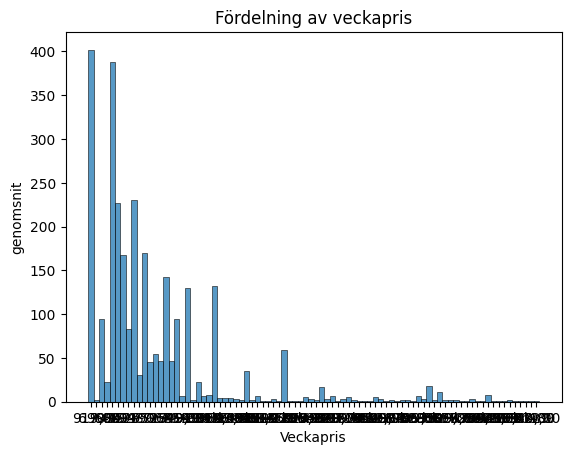

In [185]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
sns.histplot(data=df_clean, x="veckapris", bins=30)
plt.title("Fördelning av veckapris")
plt.xlabel("Veckapris")
plt.ylabel("genomsnit")
plt.show()
#prisnivåer / intäktsbildd
#Fördelningen av veckapris visar hur prissättningen är spridd och om majoriteten av kunderna ligger i samma prisintervall.


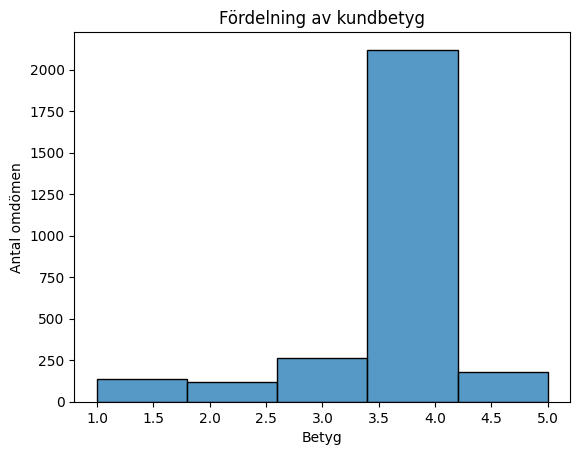

In [ ]:
plt.figure()
sns.histplot(data=df_clean, x="omdömesbetyg", bins=5)
plt.title("Fördelning av kundbetyg")
plt.xlabel("Betyg")
plt.ylabel("Antal omdömen")
plt.show()
#Nästan alla ordrar har status “Levererad”, vilket tyder på en fungerande leveransprocess.